In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

pd.set_option('display.max_columns', 50)

In [2]:
ass_data = pd.read_csv('../src/data/assessor_clean.csv', parse_dates=['CurrentSalesDate'])

/home/alex/EECS_731/EECS731_FinalProject/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preliminary Cleaning

This data is very messy, and needs some work right off the bat.  For starters, many rows have 0 or null values for key columns we want to draw conclusions on.  Some of these make sense, for instance empty lots will have a property area and assessed improvement value of 0.  Others, like a lot area of 0 seem to indicate some error in reporting.

Next, there are a number of properties where PropertyArea > LotArea * NumberofStories, which should be impossible.

Finally, a couple *huge* lots in the millions of square feet are excluded from analysis since they dwarf all others by orders of magnitude

In [3]:
ass_data = ass_data.query('PropertyArea > 0 and LotArea > 0 and NumberofStories > 0 and AssessedImprovementValue > 0')

# about 4 thousand properties are listed as having more square feet than is possible, not sure why
ass_data = ass_data.query('PropertyArea <= LotArea * NumberofStories')

ass_data = ass_data.query('LotArea < 300000')

# Data Exploration

As we would expect, a definite positive correlation exists between property area and property value.  Some anomalies can already be picked out by eye from this graph

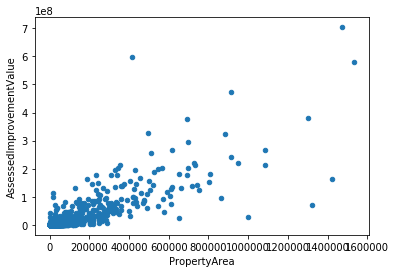

In [4]:
ass_data.plot.scatter(x='PropertyArea', y='AssessedImprovementValue')

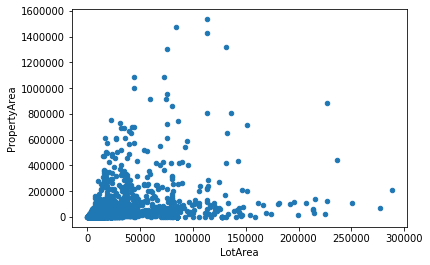

In [5]:
ass_data.plot.scatter(x='LotArea', y='PropertyArea')

In [6]:
ass_data.dtypes

ClosedRollYear                          float64
PropertyLocation                         object
ParcelNumber                             object
Block                                    object
Lot                                      object
VolumeNumber                              int64
UseCode                                  object
UseDefinition                            object
PropertyClassCode                        object
PropertyClassCodeDefinition              object
YearPropertyBuilt                       float64
NumberofBathrooms                       float64
NumberofBedrooms                          int64
NumberofRooms                             int64
NumberofStories                           int64
NumberofUnits                             int64
ZoningCode                               object
ConstructionType                         object
LotDepth                                float64
LotFrontage                             float64
PropertyArea                            

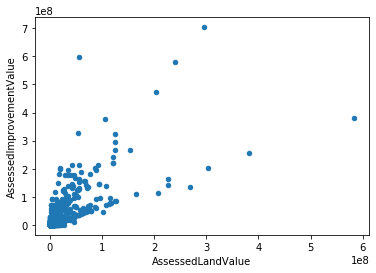

In [7]:
ass_data.plot.scatter(x='AssessedLandValue', y='AssessedImprovementValue')

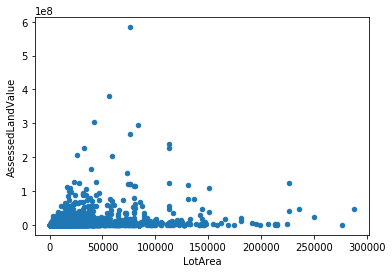

In [8]:
ass_data.plot.scatter(x='LotArea', y='AssessedLandValue')

Initial attempts at anomaly detection seem to identify "mansion" and "non-mansion" categories, which isn't too helpfull...

Feature engineering with value / sqare foot might help us out here

In [19]:
model = EllipticEnvelope(contamination=.005)
labels = model.fit_predict(ass_data[['PropertyArea', 'AssessedImprovementValue']])

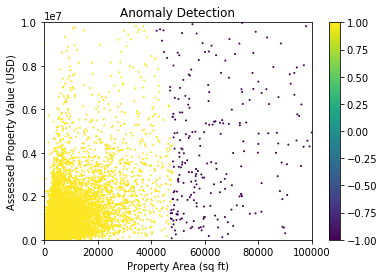

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(ass_data['PropertyArea'], ass_data['AssessedImprovementValue'], c=labels, s=1)
ax.set_title('Anomaly Detection')
ax.set_xlabel('Property Area (sq ft)')
ax.set_ylabel('Assessed Property Value (USD)')

ax.set_xlim([0, 100000])
ax.set_ylim([0, 10000000])

plt.colorbar(scatter)
plt.show()

In [11]:
anomaly = ass_data.query('AssessedImprovementValue < 10000')
anomaly

,ClosedRollYear,PropertyLocation,ParcelNumber,Block,Lot,VolumeNumber,UseCode,UseDefinition,PropertyClassCode,PropertyClassCodeDefinition,YearPropertyBuilt,NumberofBathrooms,NumberofBedrooms,NumberofRooms,NumberofStories,NumberofUnits,ZoningCode,ConstructionType,LotDepth,LotFrontage,PropertyArea,BasementArea,LotArea,LotCode,TaxRateAreaCode,PercentofOwnership,ExemptionCode,ExemptionCodeDefinition,StatusCode,MiscExemptionValue,HomeownerExemptionValue,CurrentSalesDate,AssessedFixturesValue,AssessedImprovementValue,AssessedLandValue,AssessedPersonalPropertyValue,AssessorNeighborhoodDistrict,AssessorNeighborhoodCode,AssessorNeighborhood,SupervisorDistrict,AnalysisNeighborhood,the_geom,RowID,SalesYear,SalesMonth,SalesDay,Location,X,Y
2999,2017.0,0000 0206 green st0000,0113009,0113,009,1,ind,industrial,i,industrial,NaN,0.0,0,1,1,1,rh3,d,68.75,0.0,480,0,1575.75,r,1000.0,0.125,NaN,NaN,NaN,0,0,NaT,0,1848,39880,0,8.0,8g,telegraph hill,3,north beach,point (-122.40311197342 37.800427220543),20170113009,NaN,NaN,NaN,-122.40311197342 37.800427220543,-122.403112,37.800427
4694,2017.0,0000 0083 john st0000,0180020,0180,020,2,sres,single family residential,d,dwelling,NaN,1.0,0,4,1,1,rh3,d,0.00,0.0,441,0,1123.00,NaN,1000.0,1.000,NaN,NaN,NaN,0,0,NaT,0,6340,33616,0,8.0,8c,nob hill,3,chinatown,point (-122.411219064818 37.79579482909),20170180020,NaN,NaN,NaN,-122.411219064818 37.79579482909,-122.411219,37.795795
6075,2017.0,0000 0025 water st0000,0051016a,0051,016a,1,misc,miscellaneous/mixed-use,x,misc,NaN,1.0,0,1,1,1,nbeach,d,39.50,0.0,1777,0,2271.25,r,1000.0,1.000,NaN,NaN,NaN,0,0,2008-12-24,0,7746,43485,0,8.0,8d,north beach,3,north beach,point (-122.413963399504 37.804221651233),20170051016a,2008.0,12.0,24.0,-122.413963399504 37.804221651233,-122.413963,37.804222
7183,2017.0,0000 0002 dunne's 0000,0144019,0144,019,2,misc,miscellaneous/mixed-use,x,misc,NaN,0.0,0,1,1,1,rm2,d,0.00,0.0,820,0,3031.00,o,1000.0,1.000,NaN,NaN,NaN,0,0,NaT,0,5351,126040,0,8.0,8g,telegraph hill,3,north beach,point (-122.404939121033 37.798470284352),20170144019,NaN,NaN,NaN,-122.404939121033 37.798470284352,-122.404939,37.798470
7763,2017.0,0000 0626vgreen st0000,0117006,0117,006,1,misc,miscellaneous/mixed-use,x,misc,NaN,0.0,0,1,1,1,nbeach,d,30.00,0.0,96,0,4125.00,r,1000.0,1.000,NaN,NaN,NaN,0,0,NaT,0,1867,601125,0,8.0,8d,north beach,3,chinatown,point (-122.409875458231 37.799685872079),20170117006,NaN,NaN,NaN,-122.409875458231 37.799685872079,-122.409875,37.799686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196240,2017.0,0000 0087 cotter st0000,6797028,6797,028,40,sres,single family residential,d,dwelling,NaN,1.0,0,4,1,1,rh1,d,0.00,0.0,750,0,2495.00,NaN,1000.0,1.000,11,home owners,NaN,0,7000,NaT,0,8738,28838,0,10.0,10h,mission terrace,11,outer mission,point (-122.434759709099 37.727820851152),20176797028,NaN,NaN,NaN,-122.434759709099 37.727820851152,-122.434760,37.727821
198349,2017.0,0000 0349 ellington av0000,7066017,7066,017,42,sres,single family residential,d,dwelling,NaN,1.0,0,3,1,1,rh1,d,0.00,0.0,350,0,3332.00,NaN,1000.0,1.000,NaN,NaN,NaN,0,0,NaT,0,2763,24455,0,10.0,10d,outer mission,11,outer mission,point (-122.445878410867 37.712527309396),20177066017,NaN,NaN,NaN,-122.445878410867 37.712527309396,-122.445878,37.712527
198442,2017.0,0000 0048 santa cruz av0000,7174061,7174,061,43,sres,single family residential,d,dwelling,NaN,2.0,3,7,2,0,rh1,row,0.00,0.0,1656,0,2165.00,r,1000.0,1.000,11,home owners,NaN,0,7000,2007-09-27,0,8276,288598,0,10.0,10d,outer mission,11,outer mission,point (-122.46587669756 37.709008151582),20177174061,2007.0,9.0,27.0,-122.46587669756 37.709008151582,-122.465877,37.709008
198508,2017.0,0000 0843 duncan st0000,7519011,7519,011,44,misc,miscellaneous/mixed-use,x,misc,NaN,0.0,0,0,1,0,rh1,d,0.00,0.0,324,0,2962.00,NaN,1000.0,0.500,NaN,NaN,NaN,0,0,NaT,0,3942,32406,0,4.0,4b,diamond heights,8,noe valley

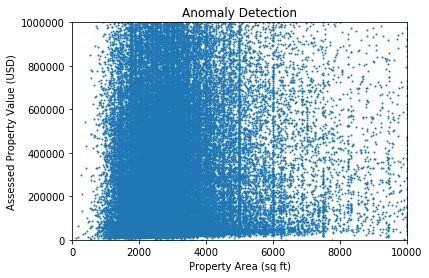

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(ass_data['LotArea'], ass_data['AssessedLandValue'], s=1)
ax.set_title('Anomaly Detection')
ax.set_xlabel('Lot Area (sq ft)')
ax.set_ylabel('Assessed Lot Value (USD)')

ax.set_xlim([0, 10000])
ax.set_ylim([0, 1000000])

plt.show()